In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
engine.execute("select * from measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
engine.execute("select * from station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

twelve_months = dt.date(2017, 8 ,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

one_year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > twelve_months).\
    order_by(Measurement.date.desc()).all()
        
# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(one_year_prcp, columns = ["Date", "Precipitation"]).set_index('Date')[::-1]
prcp_df.dropna(axis=0, inplace = True)
prcp_df = prcp_df.reset_index()

prcp_df.head(10)



,Date,Precipitation
0,2016-08-24,1.45
1,2016-08-24,2.15
2,2016-08-24,1.22
3,2016-08-24,2.28
4,2016-08-24,2.15
5,2016-08-24,0.08
6,2016-08-25,0.11
7,2016-08-25,0.06
8,2016-08-25,0.21
9,2016-08-25,0.00


![precipitation](Images/precipitation.png)

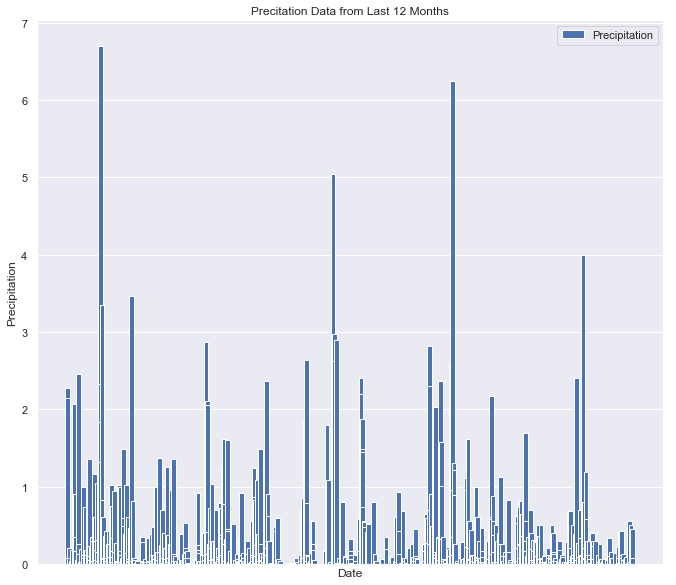

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
import seaborn as sns
sns.set()

plt.figure(figsize=(10,10))
plt.bar(prcp_df['Date'], prcp_df['Precipitation'], width = 3, label = "Precipitation")
plt.tick_params(labelbottom=False)
plt.xlabel("Date", size = "medium")
plt.ylabel("Precipitation", size = "medium")
plt.grid(axis = 'x')
plt.title("Precitation Data from Last 12 Months", size = "medium")
plt.legend()
plt.show()
# Rotate the xticks for the dates

In [15]:
# How many stations are available in this dataset?


station_count = session.query(Station.station).count()
station_count


9

In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.

engine.execute('''select station, count(prcp) 
                  from measurement
                  group by station
                  order by count(prcp) desc''').fetchall()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

engine.execute('''select min(tobs), max(tobs), avg(tobs) 
                  from measurement
                  where station = 'USC00519281'
                  group by station''').fetchall()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Temperature vs Frequency for USC00519281 Station')

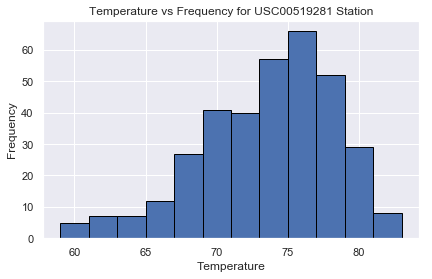

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active = engine.execute('''select station, count(tobs) 
                                from measurement
                                group by station
                                order by count(tobs) desc limit 1''').fetchall()
# most_active = USC00519281

tobs_data = engine.execute(f"select date, tobs from measurement where date > '{twelve_months}' and station = 'USC00519281'").fetchall()
tobs_df = pd.DataFrame(tobs_data, columns=["Date", "Tobs"])



tobs_df.head()

# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.hist(tobs_df["Tobs"], bins = 12, edgecolor = "black")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature vs Frequency for USC00519281 Station")

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))


# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return engine.execute(f'''select min(tobs), avg(tobs), max(tobs)
                              from measurement
                              where date >= "{start_date}" and date <= "{end_date}"''').fetchall()
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]
[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps(f'{twelve_months}', dt.date(2017, 8 ,23))
trip_data = pd.DataFrame(trip_data, columns = ["Minimum Temp", "Average Temp", "Maximum Temp"])
trip_data.head()


,Minimum Temp,Average Temp,Maximum Temp
0,58.0,74.590583,87.0


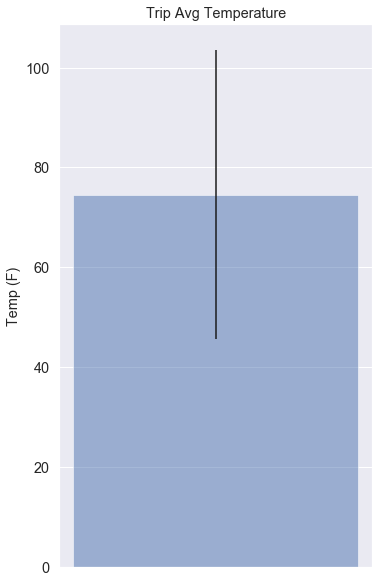

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize = (5, 10))
plt.bar(x = 0, height = trip_data["Average Temp"], yerr = trip_data["Maximum Temp"] - trip_data["Minimum Temp"], alpha = 0.5)
plt.title("Trip Avg Temperature", size = "large")
plt.grid(axis = 'x')
plt.ylabel("Temp (F)", size = "large")
plt.yticks(size = "large")
plt.tick_params(labelbottom = False)


In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

engine.execute(f'''select station, name, latitude, longitude, elevation
                   from station
                   where station in
                  (select station
                   from measurement
                   where date > "{twelve_months}"
                   group by station
                   order by sum(prcp) desc)''').fetchall()


[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]